## Imports

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Constants

In [2]:
batch_size = 128

## Data

In [3]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.MNIST('./data', transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST('./data', transform=transform, download=True, train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Utils

In [4]:
def one_hot(x, max_x):
    return torch.eye(max_x + 1)[x]

In [5]:
x = torch.tensor([3,4,5])
y = torch.tensor([
    [0,0,0,1,0,0],
])

In [6]:
def calculate_loss(model, dataloader, loss_fn=nn.MSELoss(), flatten=True, conditional=False):
    losses = []
    for batch, labels in dataloader:
        batch = batch.to(device)
        labels = labels.to(device)
        
        if flatten:
            batch = batch.view(batch.size(0), 28*28)
            
        if conditional:
            loss = loss_fn(batch, model(batch, labels))
        else:
            loss = loss_fn(batch, model(batch))
            
        losses.append(loss)

    return (sum(losses)/len(losses)).item() # calculate mean

In [7]:
def show_visual_progress(model, test_dataloader,rows=5, flatten=True, vae=False, conditional=False, title=None):
    if title:
        plt.title(title)
        
    iter(test_dataloader)
    
    image_rows = []
    
    for idx, (batch, label) in enumerate(test_dataloader):
        if rows == idx:
            break
        
        batch = batch.to(device)

        if flatten:
            batch = batch.view(batch.size(0), 28*28)

        if not conditional:
            images = model(batch).detach().cpu().numpy().reshape(batch.size(0),28,28)
        else:
            images = model(batch, label).detach().cpu().numpy().reshape(batch.size(0),28,28)

        image_idxs = [list(label.numpy()).index(x) for x in range(10)]
        combined_images = np.concatenate([images[x].reshape(28,28) for x in image_idxs],1)
        image_rows.append(combined_images)
    
    plt.imshow(np.concatenate(image_rows))
    
    
    if title:
        title = title.replace(" ", "_")
        plt.savefig(title)
    plt.show()

In [8]:
def evaluate(losses, autoencoder, dataloader, flatten=True, vae=False, conditional=False, title=""):
#     display.clear_output(wait=True)
    if vae and conditional:
        model = lambda x, y: autoencoder(x, y)[0]
    elif vae:
        model = lambda x: autoencoder(x)[0]
    else:
        model = autoencoder

    loss = calculate_loss(model, dataloader, flatten=flatten, conditional=conditional)
    show_visual_progress(model, test_dataloader, flatten=flatten, vae=vae, conditional=conditional, title=title)
    
    losses.append(loss)

In [9]:
def train(net, dataloader, test_dataloader, epochs=5, flatten=False, loss_fn=nn.MSELoss(), title=None):
    optim = torch.optim.Adam(net.parameters())
    
    train_losses = []
    validation_losses = []
    
    for i in range(epochs):
        for batch, labels in dataloader:
            batch = batch.to(device)
            
            if flatten:
                batch = batch.view(batch.size(0), 28*28)
            
            optim.zero_grad()
            loss = loss_fn(batch, net(batch))
            loss.backward()
            optim.step()
            
            train_losses.append(loss.item())
        if title:
            image_title = f'{title} - Epoch {i}'
        evaluate(validation_losses, net, test_dataloader, flatten, title=image_title)

In [79]:
def calculate_nparameters(model):
    def times(shape):
        parameters = 1
        for layer in list(shape):
            parameters *= layer
        return parameters
    
    layer_params = [times(x.size()) for x in list(model.parameters())]
    
    return sum(layer_params)

# Autoencoders

## Vanilla Autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, hidden)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

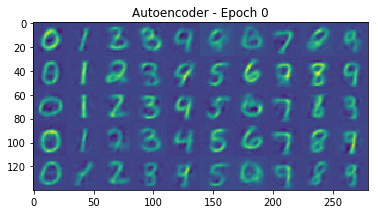

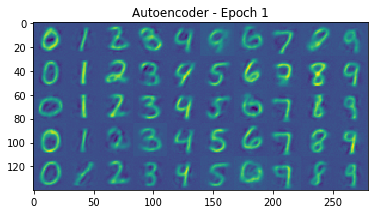

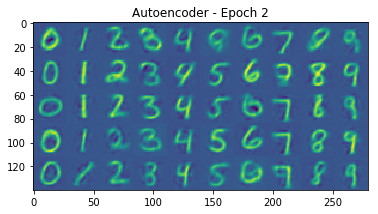

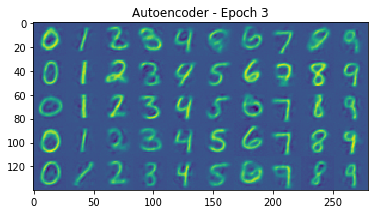

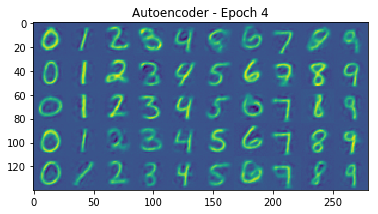

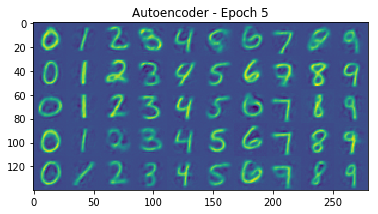

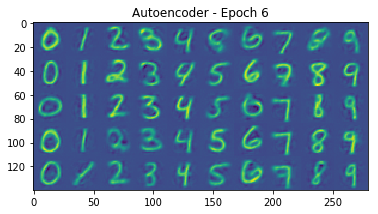

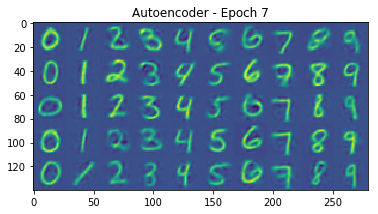

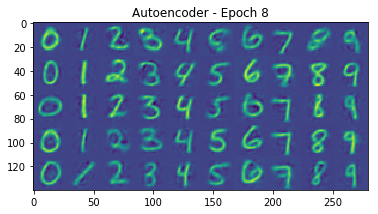

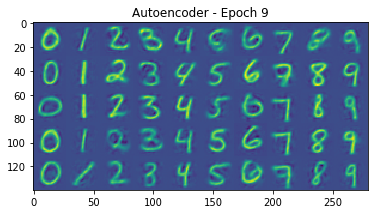

In [11]:
autoencoder = Autoencoder(28*28).to(device)
train(autoencoder, train_dataloader, test_dataloader, epochs=10, flatten=True, title='Autoencoder')

## Convolutional Autoencoder

In [12]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,(3,3),stride=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16,8,(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8,16,(3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,(5,5), stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

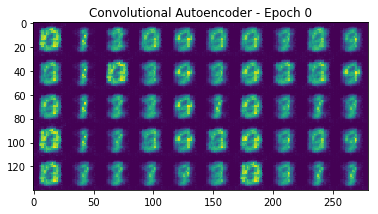

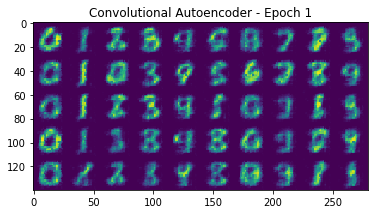

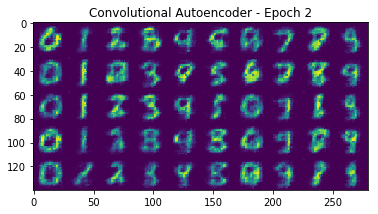

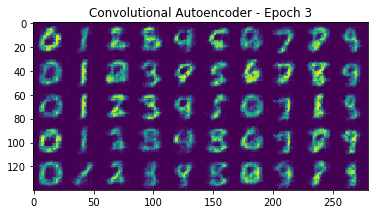

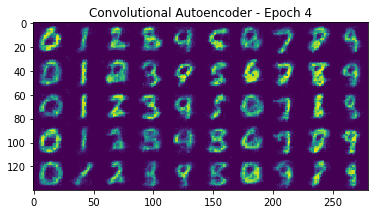

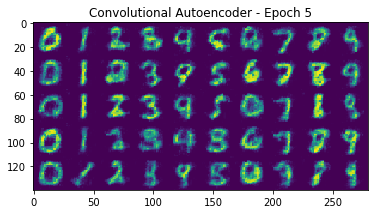

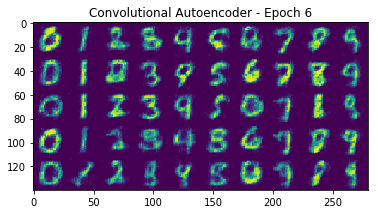

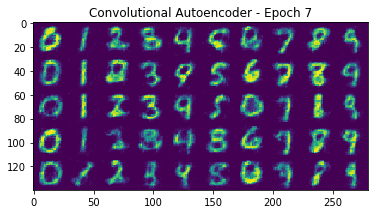

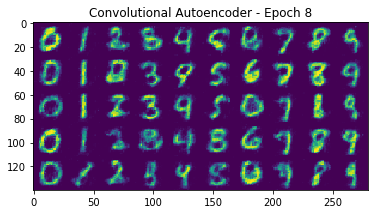

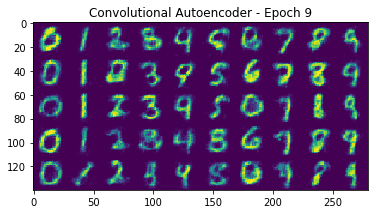

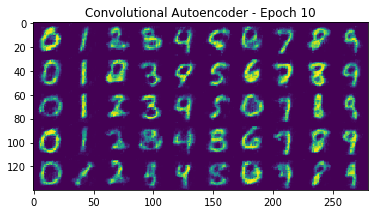

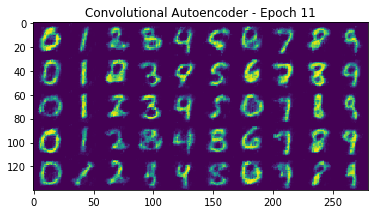

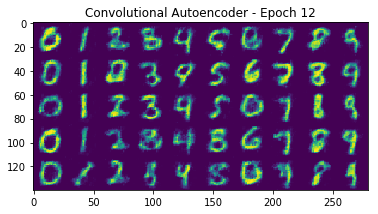

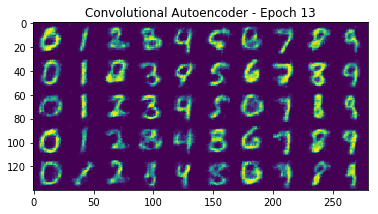

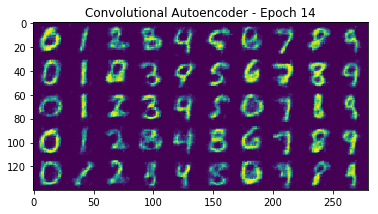

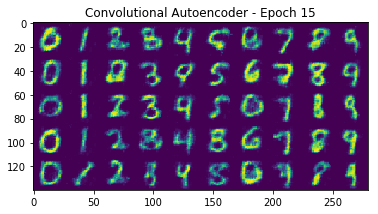

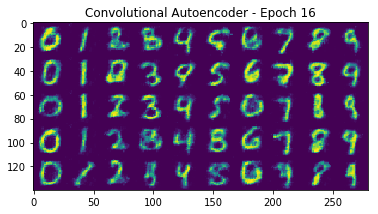

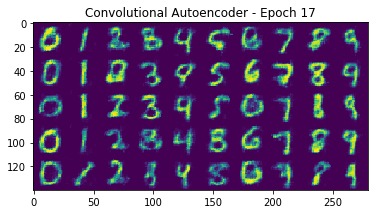

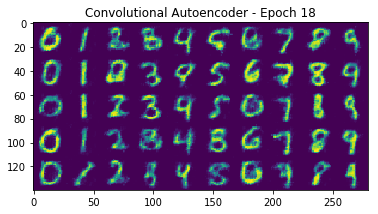

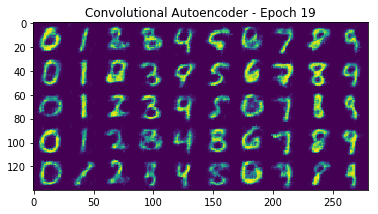

In [13]:
cnnAutoencoder = CNNAutoencoder().to(device)
train(cnnAutoencoder, train_dataloader, test_dataloader, epochs=10, title='Convolutional Autoencoder')

## Variational Autoencoder

In [44]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(VariationalAutoencoder, self).__init__()
        self.fc1 = nn.Linear(input_size,512)
        self.fc21 = nn.Linear(512, 10)
        self.fc22 = nn.Linear(512, 10)
        
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(10, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar

In [45]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [46]:
def train_vae(net, dataloader, test_dataloader, flatten=True, epochs=10):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    for i in range(epochs):
        for batch in dataloader:
            batch = batch[0].to(device)

            if flatten:
                batch = batch.view(batch.size(0), 28*28)

            optim.zero_grad()
            x,mu,logvar = net(batch)
            loss = vae_loss_fn(batch, x, mu, logvar)
            loss.backward()
            optim.step()
        evaluate(validation_losses, net, test_dataloader, vae=True, title=f'VAE - Epoch {i}')

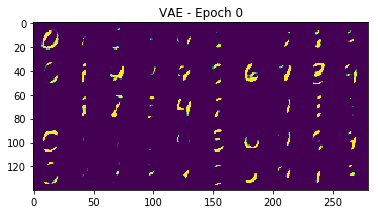

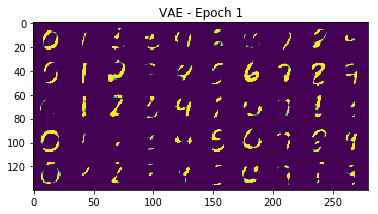

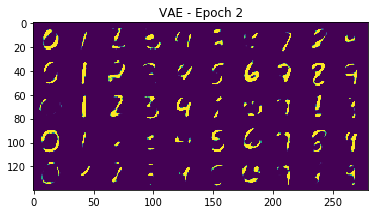

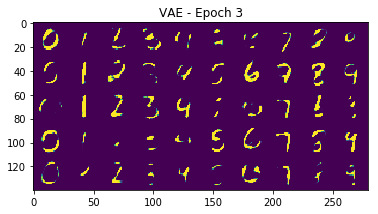

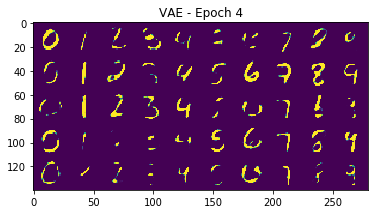

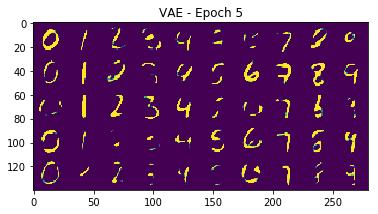

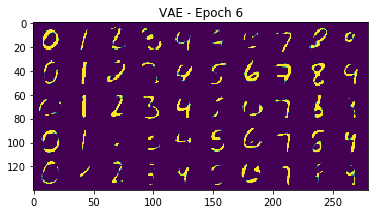

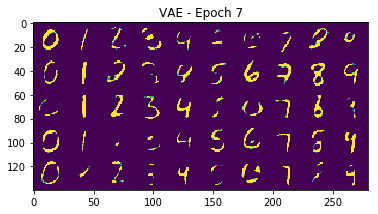

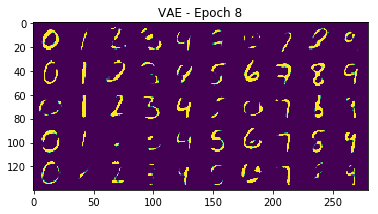

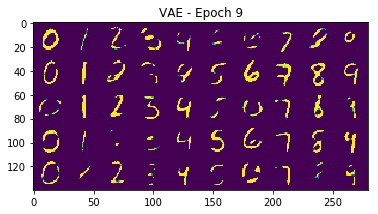

In [47]:
vae = VariationalAutoencoder(28*28).to(device)
train_vae(vae, train_dataloader, test_dataloader)

## Conditional VAE

In [18]:
class ConditionalVariationalAutoencoder(nn.Module):
    def __init__(self, input_size, max_label, hidden_size=20):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.max_label = max_label
        input_size_with_label = input_size + self.max_label + 1
        hidden_size += self.max_label + 1
        
        self.fc1 = nn.Linear(input_size_with_label,512)
        self.fc21 = nn.Linear(512, hidden_size)
        self.fc22 = nn.Linear(512, hidden_size)
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x, targets):
        x = torch.cat((x, targets), 1)
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z, targets):
        torch.cat((z, targets), 1)
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x, targets):
        targets = one_hot(targets, self.max_label).float()
        mu, logvar = self.encode(x, targets)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z, targets)
        return x, mu, logvar

In [19]:
def train_cvae(net, dataloader, test_dataloader, flatten=True, epochs=10):
    validation_losses = []
    optim = torch.optim.Adam(net.parameters())

    for i in range(epochs):
        for batch, labels in dataloader:
            batch = batch.to(device)
            labels = labels.to(device)

            if flatten:
                batch = batch.view(batch.size(0), 28*28)

            optim.zero_grad()
            x,mu,logvar = net(batch, labels)
            loss = vae_loss_fn(batch, x[:, :784], mu, logvar)
            loss.backward()
            optim.step()
        evaluate(validation_losses, net, test_dataloader, flatten=True, vae=True, conditional=True, title=f'Conditional VAE - Epoch {i}')
    plt.plot(validation_losses)
    plt.show()

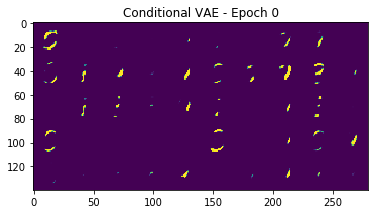

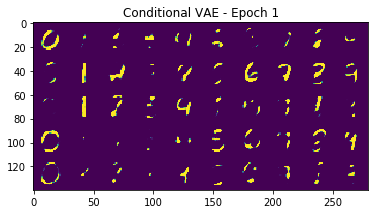

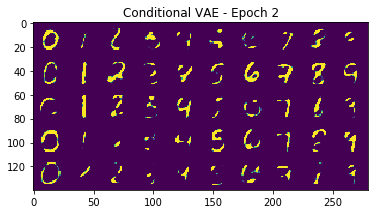

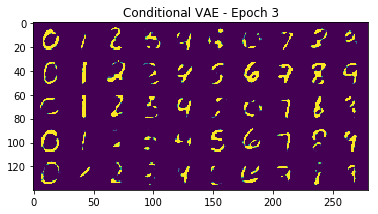

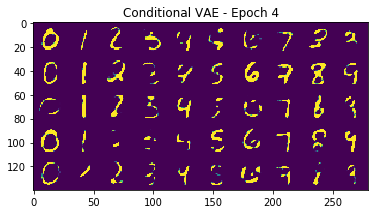

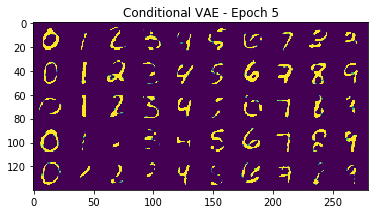

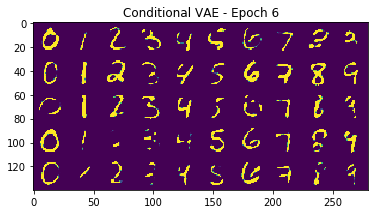

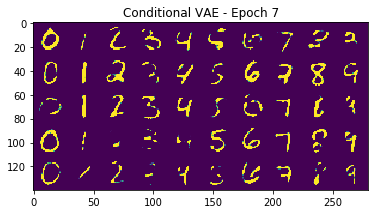

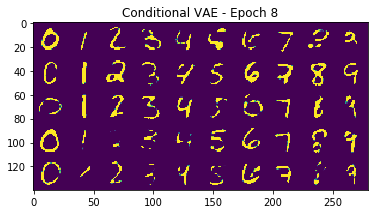

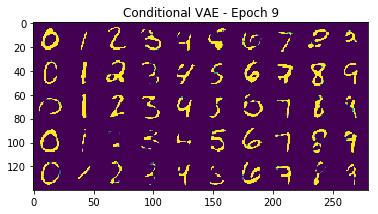

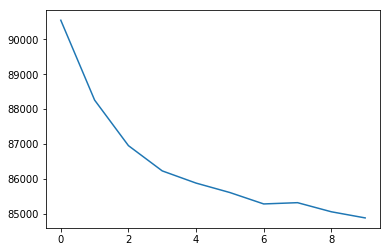

In [20]:
cvae = ConditionalVariationalAutoencoder(28*28, 10)
train_cvae(cvae, train_dataloader, test_dataloader)

## Calculate Model Parameters

In [84]:
models = [autoencoder, cnnAutoencoder, vae, cvae]

In [85]:
for model in models:
    print(calculate_nparameters(model))

938522
5729
820004
857934
